In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import f1_score, roc_auc_score

from lime.lime_tabular import LimeTabularExplainer

pd.set_option('display.max_columns', None)

In [2]:
# Class to help select categorical vs. continuous data as part of the pipeline (see below)
class DataSelector(BaseEstimator, TransformerMixin):
    '''Select columns of numpy arrays based on attribute_indices.'''

    def __init__(self, attribute_indices):
        self.attribute_indices = attribute_indices

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X)[:,self.attribute_indices]

In [3]:
# Load (preprocessed) data
# 
# The raw data was downloaded from https://data.stanford.edu/hcmst and preprocessed.
# We combined data sets collected across several years, we transformed select variables 
# (e.g., partner_education to be at the same level of granularity as education),
# and added variables like the absolute age difference, education difference, etc.
# Finally, we determined whether couples were still together (i.e., our labels).
#
# We provide the preprocessed data as a csv file in the same repo as this notebook.

df = pd.read_csv('couples.csv')

# Order features (numeric first, categorical second) since it's convenient later
feature_order = ['age',
                 'partner_age',
                 'age_diff_abs',
                 'children',
                 'visits_relatives',
                 'education',
                 'marital_status',
                 'partner_education',
                 'gender',
                 'house',
                 'income',
                 'msa',
                 'rent',
                 'political',
                 'religion',
                 'work',
                 'gender_older',
                 'education_difference',
                 'success']

data = df[feature_order]
data = data[data.house != 'boat, rv, van, etc.'] # only one data point with this value, discard

labels = data.pop('success')

In [4]:
# Take a peak at the data
data.head()

,age,partner_age,age_diff_abs,children,visits_relatives,education,marital_status,partner_education,gender,house,income,msa,rent,political,religion,work,gender_older,education_difference
0,52,48,4,0.0,0,bachelor's degree or higher,living with partner,some college,female,a building with 2 or more apartments,"$20,000 to $24,999",metro,rented for cash,democrat,catholic,working - as a paid employee,1,1
1,28,30,2,0.0,0,bachelor's degree or higher,living with partner,bachelor's degree or higher,female,a building with 2 or more apartments,"$40,000 to $49,999",metro,rented for cash,democrat,jewish,working - as a paid employee,0,0
2,31,40,9,0.0,1,some college,never married,high school,male,a building with 2 or more apartments,"$40,000 to $49,999",metro,owned or being bought by you or someone in you...,democrat,"other non-christian, please specify:",working - as a paid employee,1,1
3,53,55,2,0.0,1,bachelor's degree or higher,living with partner,bachelor's degree or higher,male,a one-family house detached from any other house,"$125,000 to $149,999",metro,owned or being bought by you or someone in you...,democrat,"protestant (e.g., methodist, lutheran, presbyt...",working - as a paid employee,1,0
4,58,51,7,0.0,0,bachelor's degree or higher,separated,bachelor's degree or higher,male,a building with 2 or more apartments,"$15,000 to $19,999",metro,rented for cash,democrat,"protestant (e.g., methodist, lutheran, presbyt...",working - as a paid employee,0,0


In [42]:
# Define categorical names and indices
categorical_features = list(data.columns[5:])
categorical_idx = list(range(5, len(data.columns)))
continuous_features = list(data.columns[0:5])
continuous_idx = list(range(0,5))

X = data.values

# Get feature names and their values for categorical data (needed for LIME)
categorical_names = {}
for idx, feature in zip(categorical_idx, categorical_features):
    le = LabelEncoder()
    X[:, idx] = le.fit_transform(X[:, idx])
    categorical_names[idx] = le.classes_

# To suppress a warning later (not strictly necessary)
X = X.astype(float)


# Train test split
train, test, labels_train, labels_test = train_test_split(
    X, labels, train_size=0.70, random_state=42
)

In [43]:
labels_train.unique(), labels_test.unique()

(array([ 1.,  0.]), array([ 1.,  0.]))

In [44]:
# Preprocessing pipeline
#      
# LIME needs a function that takes raw inputs and returns a prediction (see below).     
# We use sklearn's pipeline to handle preprocessing, it simplifies the interaction with LIME (see below). 
# There are several ways to build this pipeline. For demo purposes, we here show the verbose option (and we
# avoid scaling one-hot encoded features).

continuous_pipeline = Pipeline([
    ('selector', DataSelector(continuous_idx)),
    ('scaler', StandardScaler()),
    ])

categorical_pipeline = Pipeline([
    ('selector', DataSelector(categorical_idx)),
    ('encoder', OneHotEncoder(sparse=False)),
    ])

preprocessing_pipeline = FeatureUnion(transformer_list=[
    ("continuous_pipeline", continuous_pipeline),
    ("categorical_pipeline", categorical_pipeline),
    ])

# There are less verbose alternatives, especially if we scale one-hot encoded features,
# an accepted practice in the machine learning community:
#
#     preprocessing_pipeline = Pipeline([
#        ('onehotencoder', OneHotEncoder(categorical_features=categorical_idx, sparse=False)),
#        ('scaler', StandardScaler())
#     ])
#
# Finally, instead of the low-level Pipeline constructor, we can use sklearn's makepipeline:
#
#     preprocessing_pipeline = make_pipeline(
#         OneHotEncoder(categorical_features=categorical_idx, sparse=False),
#         StandardScaler()
#     )

In [45]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from functools import partial
from math import log, exp

In [46]:
%%time

import json
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error

# create dataset for lightgbm
lgb_train = lgb.Dataset(train, labels_train)
lgb_eval = lgb.Dataset(test, labels_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'num_leaves': 31,
    'learning_rate': 0.25,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'num_trees': 200
}

print('Start training...')
# train
gbm = lgb.cv(params,
             lgb_train,
             nfold=7)

Start training...


/home/yannick/bin/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:387: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 55 s, sys: 1.82 s, total: 56.9 s
Wall time: 11.2 s


In [47]:
np.mean(gbm['auc-mean'])

0.82149112028687499

In [54]:
%%time 

from datetime import datetime
from random import seed

seed(42)

defaults = {
    'task': 'train',
    'boosting_type': 'dart',
    'objective': 'binary',
    'metric': {'auc'},
    'verbose': 0,
    'num_trees': 900
}

trials = Trials()
the_best = 0

bagging_freq_choice = range(0, 20)

start = datetime.now()
i_eval = 0

def hyperopt_train_test(params):

    global the_best, start, i_eval
    
    params["num_leaves"] = int(params["num_leaves"])
    params["learning_rate"] = exp(params["learning_rate"])
    params["max_depth"] = int(params["max_depth"])
    params["min_data_in_leaf"] = int(params["min_data_in_leaf"])
    params["bagging_freq"] = bagging_freq_choice[params["bagging_freq"]]
    params.update(defaults)
    
    r = lgb.cv(params, 
               lgb_train,
               nfold=7,
               early_stopping_rounds=40)
   
    weight = np.mean(r['auc-mean'])
    
    i_eval += 1
    
    if the_best > -weight:
        the_best = -weight
        print(params, " => ", -weight)
        print(i_eval, str(datetime.now() - start))
    
    return -weight


space4xgb = {
    'num_leaves': hp.uniform("num_leaves", 10, 50),
    'learning_rate': hp.uniform('eta', log(0.03), log(0.5)),
    'feature_fraction': hp.uniform('feature_fraction', 0.2, 1.0),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.2, 1.0),
    'bagging_freq': hp.choice("bagging_freq", bagging_freq_choice),
    'max_depth': hp.uniform("max_depth", 1, 20),
    'min_data_in_leaf': hp.uniform("min_data_in_leaf", 0.6, 200),
    'drop_rate': hp.uniform("drop_rate", 0.01, 0.99)
}


def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': acc, 'status': STATUS_OK}


best = fmin(f, space4xgb, algo=partial(tpe.suggest, n_startup_jobs=1), max_evals=1000, trials=trials)

/home/yannick/bin/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:387: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


{'bagging_fraction': 0.6164316289100307, 'bagging_freq': 18, 'drop_rate': 0.18653843424314032, 'feature_fraction': 0.3909111559014331, 'learning_rate': 0.21264631587207708, 'max_depth': 1, 'min_data_in_leaf': 21, 'num_leaves': 10, 'task': 'train', 'boosting_type': 'dart', 'objective': 'binary', 'metric': {'auc'}, 'verbose': 0}  =>  -0.828524020534
1 0:00:01.643843
{'bagging_fraction': 0.9445178964970187, 'bagging_freq': 7, 'drop_rate': 0.8552368268213721, 'feature_fraction': 0.9131876255753225, 'learning_rate': 0.037021897338596337, 'max_depth': 12, 'min_data_in_leaf': 141, 'num_leaves': 10, 'task': 'train', 'boosting_type': 'dart', 'objective': 'binary', 'metric': {'auc'}, 'verbose': 0}  =>  -0.832412042282
3 0:00:19.022451
{'bagging_fraction': 0.7719209224605047, 'bagging_freq': 2, 'drop_rate': 0.6311731512949131, 'feature_fraction': 0.7053282749659173, 'learning_rate': 0.07678377407030611, 'max_depth': 9, 'min_data_in_leaf': 112, 'num_leaves': 42, 'task': 'train', 'boosting_type': '

In [64]:
param = {'num_trees': 184, 'bagging_fraction': 0.6681637935881612, 'bagging_freq': 0, 'drop_rate': 0.5157865385561036, 'feature_fraction': 0.9694663606488568, 'learning_rate': 0.07203935920636718, 'max_depth': 16, 'min_data_in_leaf': 65, 'num_leaves': 32, 'task': 'train', 'boosting_type': 'dart', 'objective': 'binary', 'metric': {'auc'}, 'verbose': 0}

rf = lgb.LGBMModel(**param)

pipeline = rf
pipeline.fit(train, labels_train, 
             eval_set=[(test, labels_test), (train, labels_train)],
             eval_metric="auc",
             verbose=True)

/home/yannick/bin/anaconda3/envs/py36/lib/python3.6/site-packages/lightgbm/engine.py:100: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's auc: 0.874158	valid_0's auc: 0.850067
[2]	training's auc: 0.876208	valid_0's auc: 0.852552
[3]	training's auc: 0.878574	valid_0's auc: 0.851626
[4]	training's auc: 0.879079	valid_0's auc: 0.848916
[5]	training's auc: 0.880682	valid_0's auc: 0.84959
[6]	training's auc: 0.881087	valid_0's auc: 0.850503
[7]	training's auc: 0.881017	valid_0's auc: 0.849829
[8]	training's auc: 0.881135	valid_0's auc: 0.850783
[9]	training's auc: 0.880428	valid_0's auc: 0.850194
[10]	training's auc: 0.881242	valid_0's auc: 0.850278
[11]	training's auc: 0.880862	valid_0's auc: 0.850938
[12]	training's auc: 0.881627	valid_0's auc: 0.851527
[13]	training's auc: 0.882363	valid_0's auc: 0.851219
[14]	training's auc: 0.884643	valid_0's auc: 0.851317
[15]	training's auc: 0.884349	valid_0's auc: 0.851935
[16]	training's auc: 0.884721	valid_0's auc: 0.851148
[17]	training's auc: 0.884726	valid_0's auc: 0.851317
[18]	training's auc: 0.884823	valid_0's auc: 0.850334
[19]	training's auc: 0.884775	valid_0'

[175]	training's auc: 0.907858	valid_0's auc: 0.85842
[176]	training's auc: 0.908412	valid_0's auc: 0.858757
[177]	training's auc: 0.911069	valid_0's auc: 0.859459
[178]	training's auc: 0.911203	valid_0's auc: 0.860273
[179]	training's auc: 0.912916	valid_0's auc: 0.860358
[180]	training's auc: 0.912819	valid_0's auc: 0.860386
[181]	training's auc: 0.912702	valid_0's auc: 0.860442
[182]	training's auc: 0.913034	valid_0's auc: 0.860189
[183]	training's auc: 0.912927	valid_0's auc: 0.860189
[184]	training's auc: 0.91283	valid_0's auc: 0.860217


LGBMModel(bagging_fraction=0.6681637935881612, bagging_freq=0,
     boosting_type='dart', colsample_bytree=1,
     drop_rate=0.5157865385561036, feature_fraction=0.9694663606488568,
     learning_rate=0.07203935920636718, max_bin=255, max_depth=16,
     metric={'auc'}, min_child_samples=10, min_child_weight=5,
     min_data_in_leaf=65, min_split_gain=0, n_estimators=10, nthread=-1,
     num_leaves=32, num_trees=184, objective='binary', reg_alpha=0,
     reg_lambda=0, seed=0, silent=True, subsample=1,
     subsample_for_bin=50000, subsample_freq=1, task='train', verbose=0)

In [67]:

# Evalute random forest classifier on train data
y_predict = pipeline.predict(train)
auc = roc_auc_score(labels_train, y_predict)
print('AUC on train:', auc)

# Evalute random forest classifier on test data
y_predict = pipeline.predict(test)
auc = roc_auc_score(labels_test, y_predict)
print('AUC on test:', auc)

AUC on train: 0.912830188679
AUC on test: 0.860217318059


0.7601809954751131


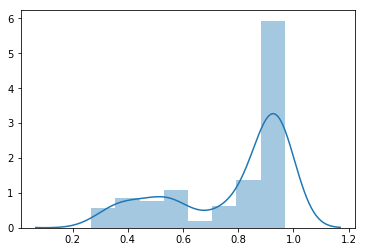

In [68]:
import seaborn as sns
%matplotlib inline

print(labels_test.mean())

sns.distplot(y_predict)

In [70]:
# Use LIME to explain individual predictions, initialize explainer object
explainer = LimeTabularExplainer(
    train,
    class_names=['BrokeUp', 'StayedTogether'],
    feature_names=list(data.columns),
    categorical_features=categorical_idx,
    categorical_names=categorical_names,
    discretize_continuous=True
)

In [75]:
# Explain a prediction ("local interpretability"): 
# Now we see that the pipeline that takes raw data and returns the prediction 
# of the trained model now comes in conveniently.
example = 3
exp = explainer.explain_instance(test[example], pipeline.predict, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

NotImplementedError: LIME does not currently support classifier models without probability scores. If this conflicts with your use case, please let us know: https://github.com/datascienceinc/lime/issues/16

Couples probability of staying together: 0.926668


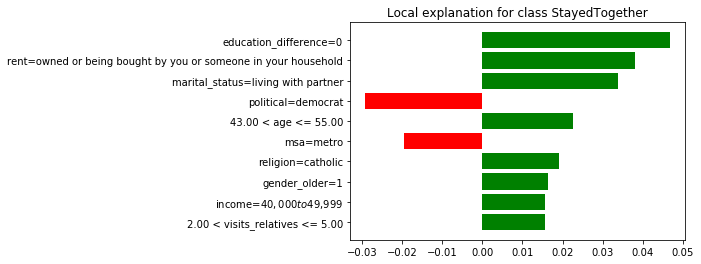

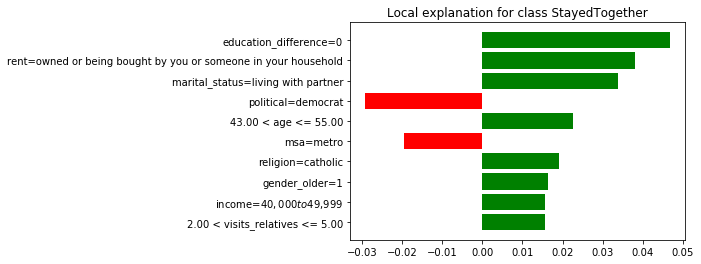

In [56]:
# Explain another prediction ("local interpretability"): 
example = 13
exp = explainer.explain_instance(test[example], pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

In [57]:
# and we see differences in explaining the model's predictions.

Couples probability of staying together: 0.870143


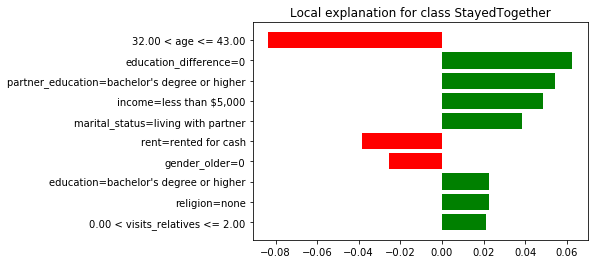

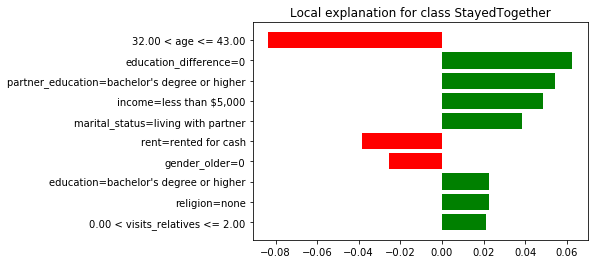

In [58]:
# Using LIME for for relationship management (not advised): Current chance of relationship success.
current = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 18, 0, 2, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(current), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.796474


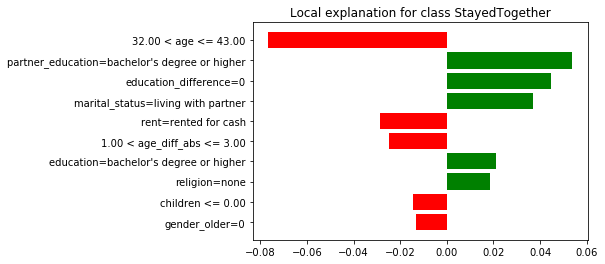

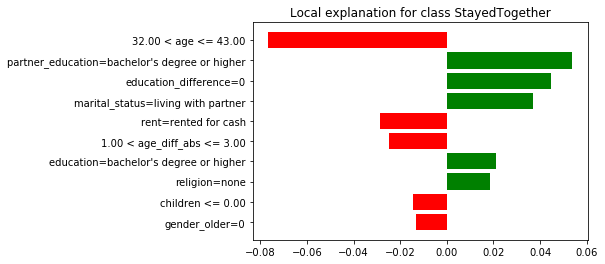

In [59]:
# Should I ask for a pay increase? It doesn't matter much.
increase_income = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 6, 0, 2, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(increase_income), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.826882


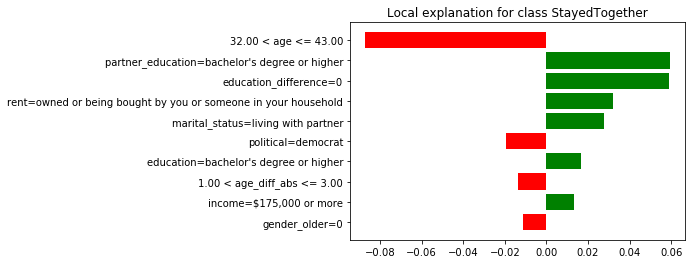

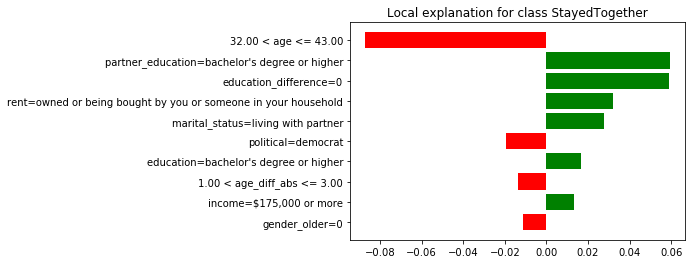

In [60]:
# Should I buy a house? Maybe?
buy_house = [34, 36, 2, 0, 1, 0, 1, 0, 0, 0, 6, 0, 1, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(buy_house), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()

Couples probability of staying together: 0.950146


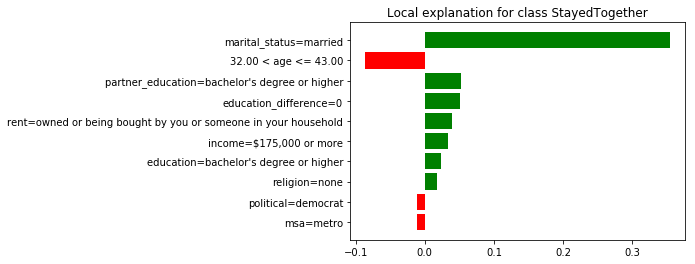

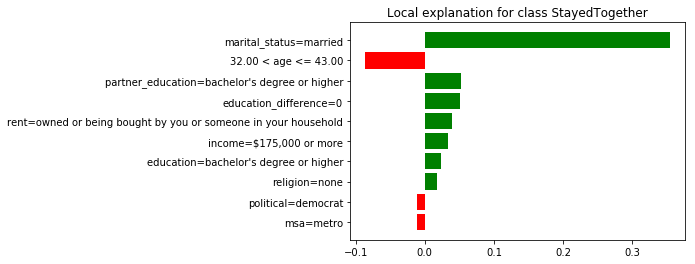

In [61]:
# Really, it's best to get married.
get_married = [34, 36, 2, 0, 1, 0, 2, 0, 0, 0, 6, 0, 1, 0, 8, 4, 0, 0]
exp = explainer.explain_instance(np.array(get_married), pipeline.predict_proba, num_features=10)
print('Couples probability of staying together:', exp.predict_proba[1])
exp.as_pyplot_figure()